Alexnet -> stack the convolutional

https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98


In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

In [3]:
test_labels.max()

9

In [4]:
CLASS_NAMES = ['airplane','automobile','bird','cat','deer','dog','frog',
               'horse','ship','truck']

In [5]:
validation_images, validation_labels = train_images[:5000], train_labels[:5000]
train_images, train_labels = train_images[5000:], train_labels[5000:]

# slices the dataset

In [6]:
train_ds= tf.data.Dataset.from_tensor_slices((train_images,train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images,test_labels))
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

# Preprocessing



tf.Tensor([6], shape=(1,), dtype=uint8)
tf.Tensor([7], shape=(1,), dtype=uint8)
tf.Tensor([9], shape=(1,), dtype=uint8)
tf.Tensor([0], shape=(1,), dtype=uint8)
tf.Tensor([5], shape=(1,), dtype=uint8)
tf.Tensor([2], shape=(1,), dtype=uint8)
tf.Tensor([3], shape=(1,), dtype=uint8)
tf.Tensor([3], shape=(1,), dtype=uint8)
tf.Tensor([3], shape=(1,), dtype=uint8)
tf.Tensor([9], shape=(1,), dtype=uint8)
tf.Tensor([0], shape=(1,), dtype=uint8)
tf.Tensor([9], shape=(1,), dtype=uint8)
tf.Tensor([2], shape=(1,), dtype=uint8)
tf.Tensor([9], shape=(1,), dtype=uint8)
tf.Tensor([1], shape=(1,), dtype=uint8)
tf.Tensor([0], shape=(1,), dtype=uint8)
tf.Tensor([2], shape=(1,), dtype=uint8)
tf.Tensor([3], shape=(1,), dtype=uint8)
tf.Tensor([9], shape=(1,), dtype=uint8)
tf.Tensor([6], shape=(1,), dtype=uint8)


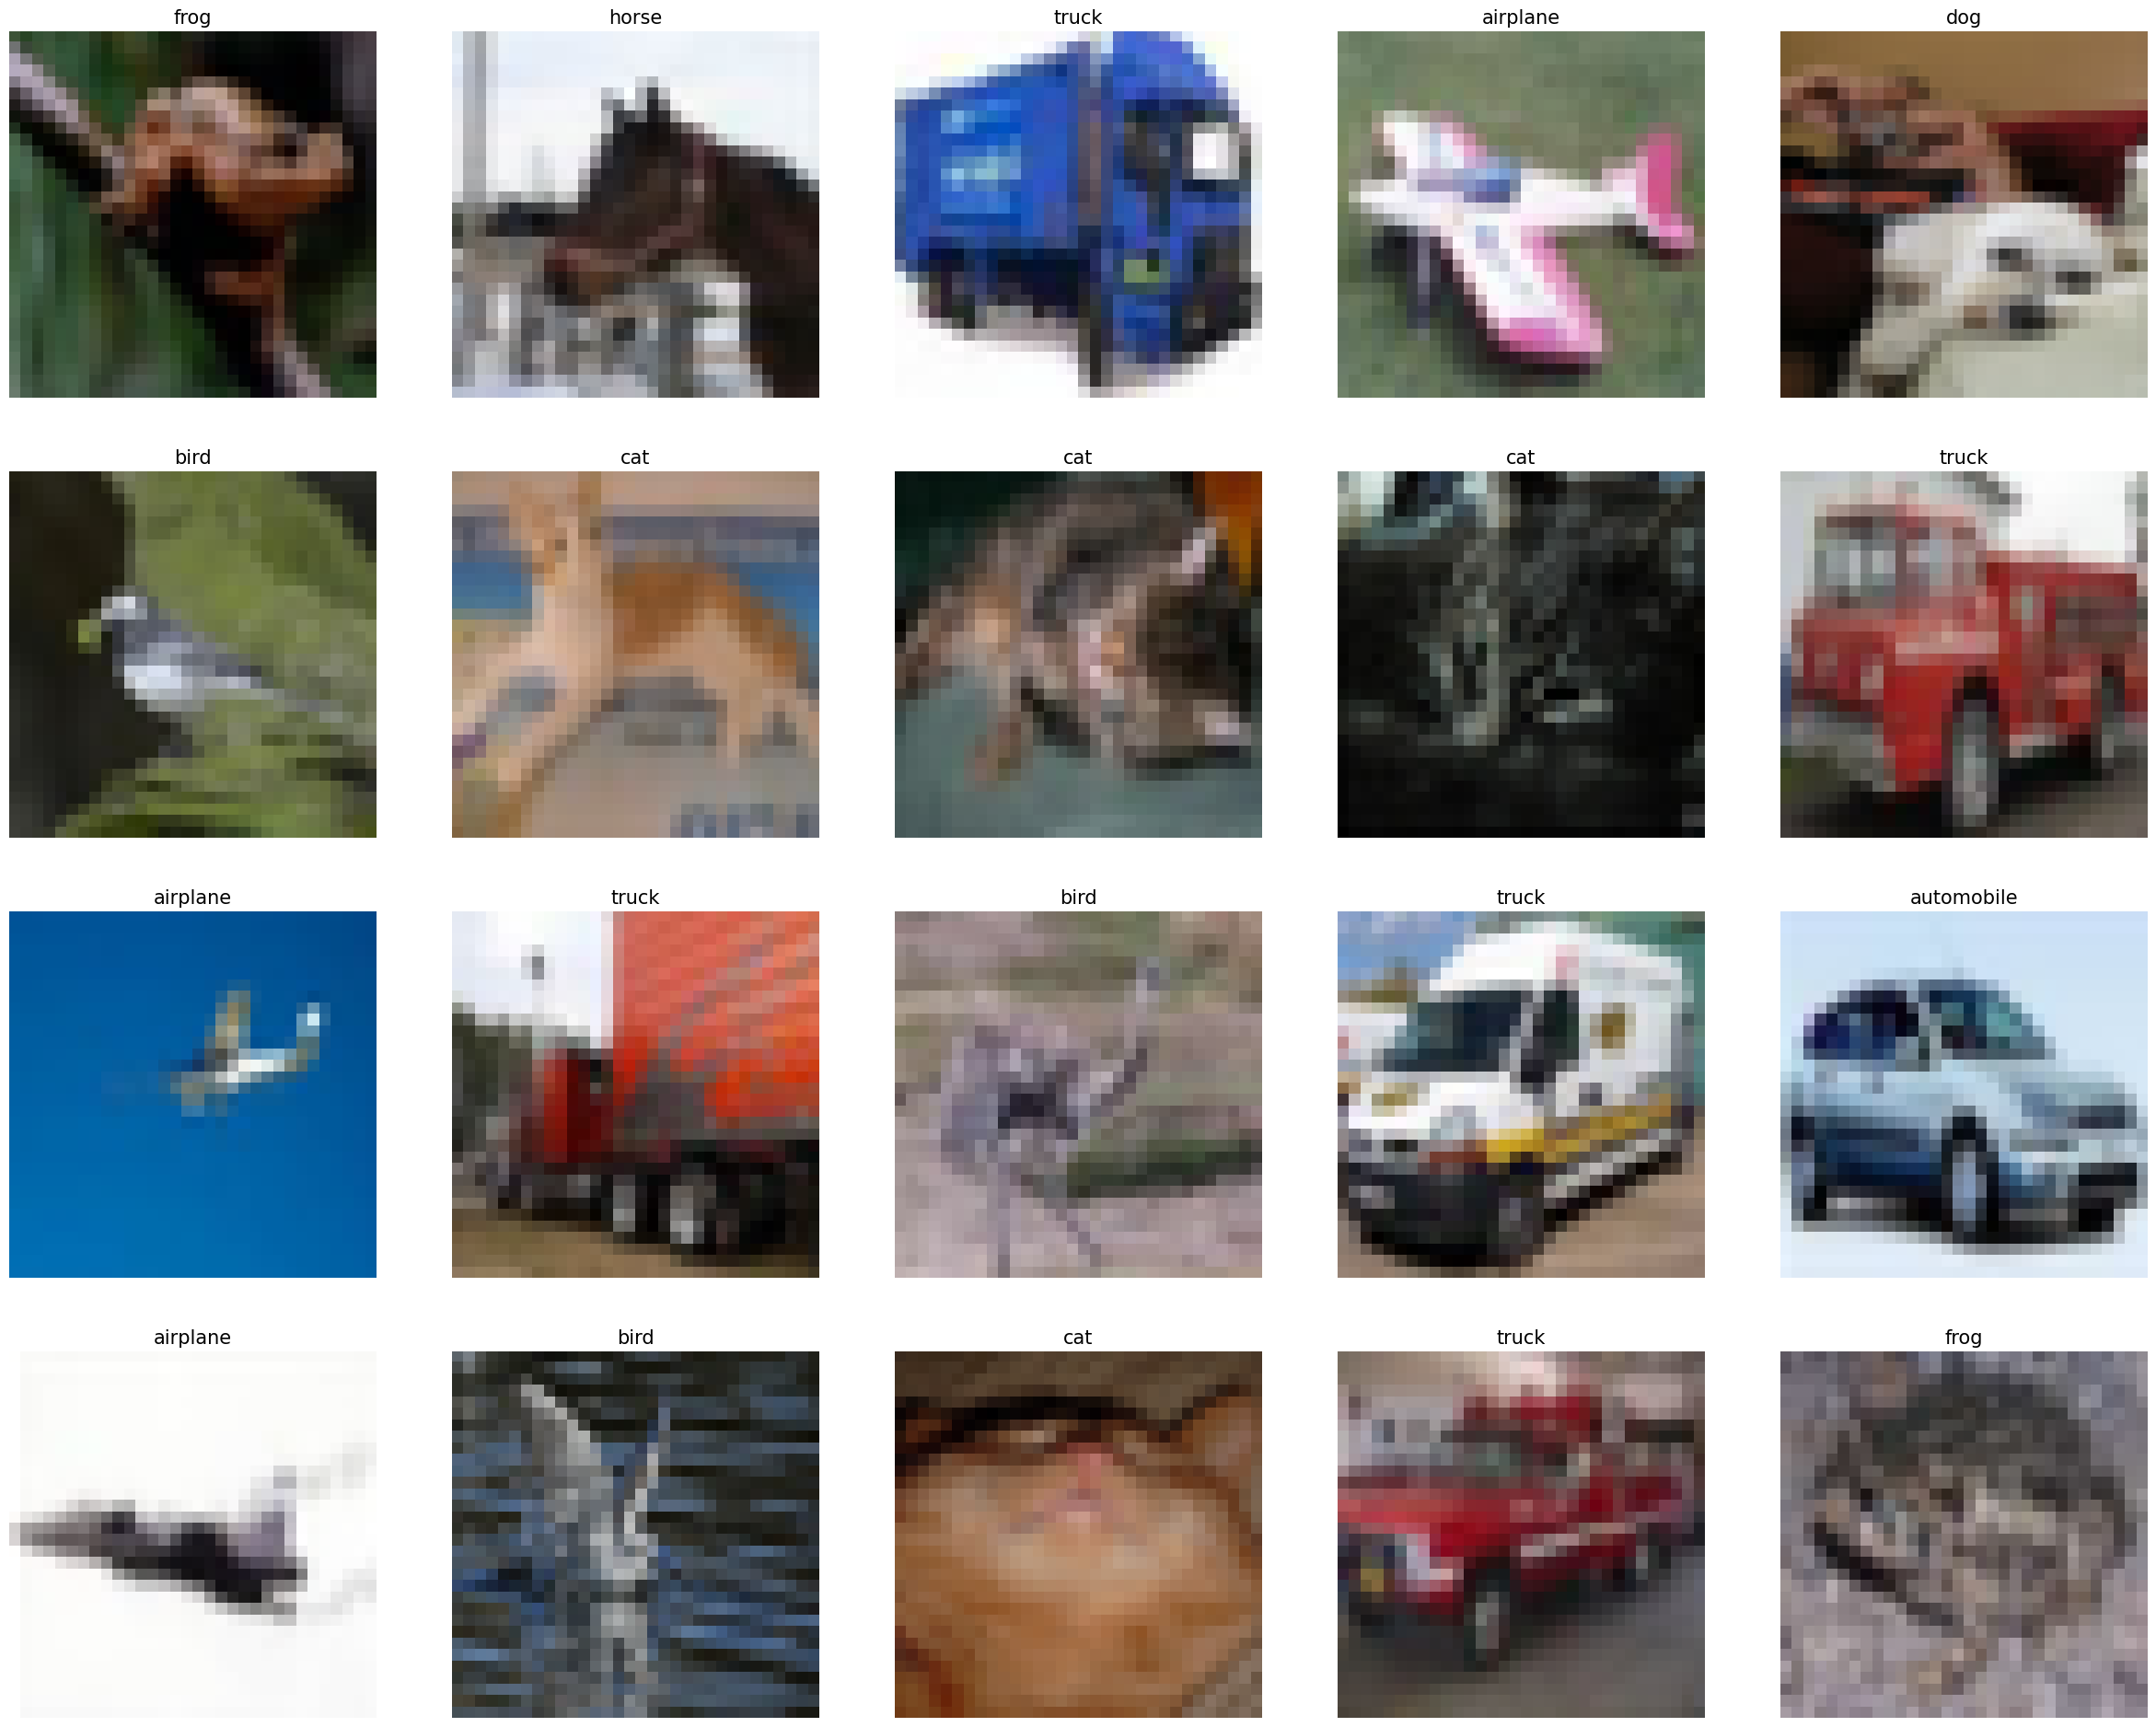

In [7]:
plt.figure(figsize=(30,30))
for i,(image,label) in enumerate(train_ds.take(20)):
    print(label)
    ax=plt.subplot(5,5,i+1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label.numpy()[0]],fontsize=15)
    plt.axis('off')

# Process images
perform all preprocessing work that we require for the data

In [8]:
def process_image(image,label):
    #Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    
    #resize images from 32x32 to 227 x 227
    image = tf.image.resize(image,(227,227))
    
    return image,label

# Pipline data


In [9]:
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy() # mencari data yang tidak duplicate
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
validation_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()
print("train size ",train_ds_size)
print("test size ",test_ds_size)

train size  45000
test size  10000


# For our basic input/data pipeline, we will conduct three primary operations:

1. Preprocessing the data within the dataset
2. Shuffle the dataset
3. Batch data within the dataset

In [10]:
train_ds = (train_ds.map(process_image)
            .shuffle(buffer_size=train_ds_size)
            .batch(batch_size=32,drop_remainder=True))

test_ds = (test_ds.map(process_image)
            .shuffle(buffer_size=train_ds_size)
            .batch(batch_size=32,drop_remainder=True))

validation_ds = (validation_ds
                  .map(process_image)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))

# Model Implemetation

![alexnet.png](images\cnn\alexnet.PNG)

In [11]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96,kernel_size=(11,11),
                        strides=(4,4),padding='valid',
                        activation='relu',input_shape=(227,227,3)),
    #local respone normalization tidak ada pada layers (use wrap lambda)
    keras.layers.Lambda(tf.nn.local_response_normalization),
    
    keras.layers.MaxPool2D(pool_size=(3,3),strides=(2,2),
                           padding='valid'),
    
    keras.layers.Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),
                        padding='same',activation='relu'),
    
    keras.layers.Lambda(tf.nn.local_response_normalization),
    
    keras.layers.MaxPool2D(pool_size=(3,3),strides=(2,2),
                           padding='valid'),
    
    # stack the conv2d after that used local respone normalization (intra channel)
    keras.layers.Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),
                        padding='same',activation='relu'),
    keras.layers.Lambda(tf.nn.local_response_normalization),
    
    keras.layers.Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),
                        padding='same',activation='relu'),
    keras.layers.Lambda(tf.nn.local_response_normalization),
    
    keras.layers.Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),
                        padding='same',activation='relu'),
    keras.layers.Lambda(tf.nn.local_response_normalization),
    
    # after stack -> maxpoling
    keras.layers.MaxPool2D(pool_size=(3,3),strides=(2,2),
                           padding='valid'),
    
    # full conenceted layers
    
    # get the 1 column
    keras.layers.Flatten(),
    keras.layers.Dense(4096,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10,activation='softmax')
])

In [12]:
import time
root_logdir = os.path.join(os.curdir, "logs\\fit\\")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [13]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.optimizers.SGD(learning_rate=1e-3),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 lambda (Lambda)             (None, 55, 55, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 lambda_1 (Lambda)           (None, 27, 27, 256)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                    

In [14]:
model.fit(train_ds,epochs=1,
          validation_data=validation_ds,
          validation_freq=1,
          callbacks=[tensorboard_cb])

1406/1406 [==============================] - 2648s 2s/step - loss: 2.2727 - accuracy: 0.1593 - val_loss: 2.1700 - val_accuracy: 0.2480


In [15]:
!tensorboard --logdir logs